# Q-learning with Function Approximation for Time Series Anomaly Detection (RNN n-n, boosted binary tree)
RNN n-n means the function approximator is basically a neural network model with n dimensional inputs and n dimensional output. In this file, we made the following changes.

1. Use binary tree to estimate the action-value function in order to provide more accurate training dataset.

## Import the Library

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import sys
import csv
import os
import time

import tensorflow as tf

from tensorflow.contrib import rnn
from mpl_toolkits.mplot3d import axes3d
from collections import deque, namedtuple

# import the library in the sub-folder env
from env.time_series_repo_ext import EnvTimeSeriesfromRepo

In [2]:
# macros for running q-learning
DATAFIXED = 0           # whether target at a single time series dataset

EPISODES = 500          # number of episodes for training
DISCOUNT_FACTOR = 0.5   # reward discount factor [0,1]
EPSILON = 0.5           # epsilon-greedy method parameter for action selection
EPSILON_DECAY = 1.00    # epsilon-greedy method decay parameter

NOT_ANOMALY = 0
ANOMALY = 1

action_space = [NOT_ANOMALY, ANOMALY]
action_space_n = len(action_space)

n_steps = 25        # size of the slide window for SLIDE_WINDOW state and reward functions
n_input_dim = 2     # dimension of the input for a LSTM cell
n_hidden_dim = 64   # dimension of the hidden state in LSTM cell

## Q-learning: State Function & Reward Function

In [3]:
# Reward Values
TP_Value = 5
TN_Value = 1
FP_Value = -1
FN_Value = -5

In [4]:
# The state function returns a vector composing of n_steps of n_input_dim data instances:
# e.g., [[x_1, f_1], [x_2, f_2], ..., [x_t, f_t]] of shape (n_steps, n_input_dim)
# x_t is the new data instance. t here is equal to n_steps

def RNNBinaryStateFuc(timeseries, timeseries_curser, previous_state=[], action=None):
    if timeseries_curser == n_steps:
        state = []
        for i in range(timeseries_curser):
            state.append([timeseries['value'][i], 0])
        
        state.pop(0)
        state.append([timeseries['value'][timeseries_curser], 1])
        
        return np.array(state, dtype='float32')
    
    if timeseries_curser > n_steps:
        state0 = np.concatenate((previous_state[1:n_steps],
                                 [[timeseries['value'][timeseries_curser], 0]]))
        state1 = np.concatenate((previous_state[1:n_steps],
                                 [[timeseries['value'][timeseries_curser], 1]]))
    
        return np.array([state0, state1], dtype='float32')
    
# Also, because we use binary tree here, the reward function returns a list of rewards for each action
def RNNBinaryRewardFuc(timeseries, timeseries_curser, action=0):
    if timeseries_curser >= n_steps:
        if timeseries['anomaly'][timeseries_curser] == 0:
            return [TN_Value, FP_Value]

        if timeseries['anomaly'][timeseries_curser] == 1:
            return [FN_Value, TP_Value]
    else:
        return [0,0]

## Q-learning: Q Function Approximator

In [5]:
class Q_Estimator_Nonlinear():
    """
    Action-Value Function Approximator Q(s,a) with Tensorflow RNN.
    Note: The Recurrent Neural Network is used here !
    """
    
    def __init__(self, learning_rate=np.float32(0.01), scope="Q_Estimator_Nonlinear", summaries_dir=None):
        self.scope = scope
        self.summary_writer = None
        
        with tf.variable_scope(scope):
            # tf Graph input
            # The input to the rnn is typically of the shape:
            # [batch_size, n_steps, n_input_dim]
            # RNN requires the data of the shape:
            # n_steps tensors of [batch_size, n_input_dim]
            self.state = tf.placeholder(shape=[None, n_steps, n_input_dim],
                                        dtype=tf.float32, name = "state")
            self.target = tf.placeholder(shape=[None, action_space_n],
                                         dtype=tf.float32, name = "target")
            
            # Define weights
            self.weights = {
                'out': tf.Variable(tf.random_normal([n_hidden_dim, action_space_n]))
            }
            self.biases = {
                'out': tf.Variable(tf.random_normal([action_space_n]))
            }
            
            self.state_unstack = tf.unstack(self.state, n_steps, 1)

            # Define a lstm cell with tensorflow
            lstm_cell = rnn.BasicLSTMCell(n_hidden_dim, forget_bias=1.0)

            # Get lstm cell output
            self.outputs, self.states = rnn.static_rnn(lstm_cell, 
                                                       self.state_unstack, 
                                                       dtype=tf.float32)

            # Linear activation, using rnn inner loop last output
            self.action_values = tf.matmul(self.outputs[-1], self.weights['out']) + self.biases['out']
            
            # Loss and train op
            self.losses = tf.squared_difference(self.action_values, self.target)
            self.loss = tf.reduce_mean(self.losses)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss, 
                                                    global_step=tf.contrib.framework.get_global_step())
            
            # Summaries for Tensorboard
            self.summaries = tf.summary.merge([
                tf.summary.histogram("loss_hist", self.losses),
                tf.summary.scalar("loss", self.loss),
                tf.summary.histogram("q_values_hist", self.action_values),
                tf.summary.scalar("q_value", tf.reduce_max(self.action_values))
            ])
    
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_values, {self.state: state})

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state, self.target: target}
        summaries, global_step, _ = sess.run([self.summaries, tf.contrib.framework.get_global_step(),
                                              self.train_op], feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return

In [6]:
def copy_model_parameters(sess, estimator1, estimator2):
    """
    Copies the model parameters of one estimator to another.

    Args:
      sess: Tensorflow session instance
      estimator1: Estimator to copy the paramters from
      estimator2: Estimator to copy the parameters to
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)

    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)

    sess.run(update_ops)

## Q-learning: Learning & other Functions

In [7]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action. float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation, epsilon):
        A = np.ones(nA, dtype='float32') * epsilon / nA
        q_values = estimator.predict(state=[observation])
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [8]:
def q_learning(env,
               qlearn_estimator,
               target_estimator,
               num_episodes,
               num_epoches,
               replay_memory_size=500000,
               replay_memory_init_size=50000,
               experiment_dir='./log/',
               update_target_estimator_every=10000,
               discount_factor=0.99,
               epsilon_start=1.0,
               epsilon_end=0.1,
               epsilon_decay_steps=500000,
               batch_size=512,
               test=0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: The environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        NULL
    """ 
    # 1. Define some useful variable
    # To memory
    Transition = namedtuple("Transition", ["state", "reward", "next_state", "done"])
    
    # The replay memory
    replay_memory = []
    
    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # Load a previous checkpoint if we find one
    saver = tf.train.Saver()
    
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    else:
        print("No model checkpoit is found!")
    
    # For testing the learnt model, return here
    # It should restore a previous sess (check printed info)
    if test:
        return
    
    # Get the time step
    total_t = sess.run(tf.contrib.framework.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(
        qlearn_estimator,
        env.action_space_n)
    
    
    # 2. Populate the replay memory with initial experience
    popu_time = time.time()
    
    state = env.reset()
    for i in range(replay_memory_init_size):
        action_probs = policy(state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        next_state, reward, done, _ = env.step(action)
        
        replay_memory.append(Transition(state, reward, next_state, done))
        
        if done:
            state = env.reset()
        else:
            state = next_state[action]
            
    popu_time = time.time() - popu_time
    print("Populating replay memory with time {}".format(popu_time))
    
    
    # 3. Start the main loop
    for i_episode in range(num_episodes):     
        # Save the current checkpoint   
        if i_episode%50 == 49:
            print("Save checkpoint in episode {}/{}".format(i_episode + 1, num_episodes))
            saver.save(tf.get_default_session(), checkpoint_path)
        
        
        per_loop_time1 = time.time()
        
        # Reset the environment
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():    
            # 3.1 Some Preprocess
            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]
            
            # 3.2 The main work
            # Choose an action to take
            action_probs = policy(state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # 3.3 Control replay memory
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)
                
            replay_memory.append(Transition(state, reward, next_state, done))
            
            if done:
                break
            
            state = next_state[action]
        
        
        per_loop_time2 = time.time()
                
        # Update the model
        for i_epoch in range(num_epoches):
            # Add epsilon to Tensorboard
            if qlearn_estimator.summary_writer:
                episode_summary = tf.Summary()
                qlearn_estimator.summary_writer.add_summary(episode_summary, total_t)

            # Update the target estimator
            if total_t % update_target_estimator_every == 0:
                copy_model_parameters(sess, qlearn_estimator, target_estimator)
                print("\nCopied model parameters to target network.\n")
                
            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
            
            if discount_factor > 0:
            # Calculate q values and targets
                next_states_batch = np.squeeze(np.split(next_states_batch, 2, axis=1))
                next_states_batch0 = next_states_batch[0]
                next_states_batch1 = next_states_batch[1]

                q_values_next0 = target_estimator.predict(state=next_states_batch0)
                q_values_next1 = target_estimator.predict(state=next_states_batch1)

                targets_batch = reward_batch + (discount_factor * 
                                                np.stack((np.amax(q_values_next0, axis=1), 
                                                          np.amax(q_values_next1, axis=1)), 
                                                         axis=-1))
            else:
                targets_batch = reward_batch

            # Perform gradient descent update
            qlearn_estimator.update(state=states_batch, target=targets_batch.astype(np.float32))
            
            total_t += 1
        
        # Print out which step we're on, useful for debugging.
        per_loop_time_popu = per_loop_time2 - per_loop_time1
        per_loop_time_updt = time.time() - per_loop_time2
        print("Global step {} @ Episode {}/{}, time: {} + {}"
              .format(total_t, i_episode + 1, num_episodes, per_loop_time_popu, per_loop_time_updt))
    return

In [9]:
def q_learning_validator(env, estimator, num_episodes, record_dir, plot):
    """
    With 1) the trained estimator of Q(s,a) action-value function, i.e., estimator
         2) the known envivronment, i.e., env
         
    Test the validity of the estimator in the application of time series anomaly detection.
    
    Args:
        env: The environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
    
    Returns:
        Statistics
    """
    if record_dir:
        rec_file = open('./{}'.format(record_dir), 'wb')
        rec_writer = csv.writer(rec_file)
    
    for i_episode in range(num_episodes):
        print("Episode {}/{}".format(i_episode + 1, num_episodes))
            
        state_rec = []
        action_rec = []
        reward_rec = []
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, env.action_space_n)
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():            
            # Choose an action to take
            action_probs = policy(state, 0)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Record the statistics
            state_rec.append(state[len(state)-1][0])
            action_rec.append(action)
            reward_rec.append(reward[action])
            
            if done:
                break
                
            state = next_state[action]
        
        # Search over reward_rec to correct the rewards
        # 1) If FN happend within a small range of TP (miss alarm very closer to reported anomaly), correct it
        # 2) If FP happend within a small range of TP (false alarm very close to the reported anomaly), correct it
        RNG = 5
        for i in range(len(reward_rec)):
            if reward_rec[i] < 0:
                low_range = max(0,i-RNG)
                up_range = min(i+RNG+1,len(reward_rec))
                r = reward_rec[low_range:up_range]
                if r.count(TP_Value) > 0:
                    reward_rec[i] = -reward_rec[i]
    
        # Plot the result for each episode
        if plot:
            f, axarr = plt.subplots(2, sharex=True)
            axarr[0].plot(state_rec)
            axarr[0].set_title('Time Series')
            axarr[1].plot(action_rec, color='g')
            axarr[1].set_title('Action')
            #axarr[2].plot(reward_rec, color='r')
            #axarr[2].set_title('Reward')
            plt.show()
        
        # Calculate the accuracy F1-score = 2*((precison*recall)/(precison+recall))
        # precision = tp / (tp+fp)
        # recall = tp / (tp+fn)
        tp = reward_rec.count(TP_Value)
        fp = reward_rec.count(FP_Value)
        fn = reward_rec.count(FN_Value)
        precision = (tp+1)/float(tp+fp+1)
        recall = (tp+1)/float(tp+fn+1)
        f1 = 2*((precision*recall)/(precision+recall))
        
        if record_dir:
            rec_writer.writerow([f1])
            
        print("Precision:{}, Recall:{}, F1-score:{} (f1 wrote to file)".format(precision, recall, f1))

    if record_dir:        
        rec_file.close()
    
    return

## Train the Action-Value Function Q(s,a) with Q-learning
1. Init the Q(s,a) action-value function estimator
2. Train the estimator with Q-learning

test = 0
plot = 1

percentage = ['0.2', '0.35', '0.5', '0.65', '0.8']

for j in range(len(percentage)):
    # Where we save our checkpoints and graphs
    exp_relative_dir = ['RNN Binary d0.9 s25 h64 b256 A1_partial_data_' + percentage[j], 'RNN Binary d0.9 s25 h64 b256 A2_partial_data_' + percentage[j],
                        'RNN Binary d0.9 s25 h64 b256 A3_partial_data_' + percentage[j], 'RNN Binary d0.9 s25 h64 b256 A4_partial_data_' + percentage[j]]

    # Which dataset we are targeting
    dataset_dir = ['env/time_series_repo/A1Benchmark', 'env/time_series_repo/A2Benchmark',
                   'env/time_series_repo/A3Benchmark', 'env/time_series_repo/A4Benchmark']

    for i in range(len(dataset_dir)):

        env = EnvTimeSeriesfromRepo(dataset_dir[i])
        env.statefnc = RNNBinaryStateFuc
        env.rewardfnc = RNNBinaryRewardFuc
        env.timeseries_curser_init = n_steps
        env.datasetfix = DATAFIXED
        
        if test==1:
            env.datasetrng = env.datasetsize
        else:
            env.datasetrng = np.int32(env.datasetsize * float(percentage[j]))
            
        env.datasetidx = 0

        experiment_dir = os.path.abspath("./exp/{}".format(exp_relative_dir[i]))

        tf.reset_default_graph()

        global_step = tf.Variable(0, name="global_step", trainable=False)

        qlearn_estimator = Q_Estimator_Nonlinear(scope="qlearn", summaries_dir=experiment_dir)
        target_estimator = Q_Estimator_Nonlinear(scope="target")

        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        with sess.as_default():
            q_learning(env,
                       qlearn_estimator=qlearn_estimator,
                       target_estimator=target_estimator,
                       num_episodes=2000,
                       num_epoches=10,
                       experiment_dir=experiment_dir,
                       replay_memory_size=50000,
                       replay_memory_init_size=50000,
                       update_target_estimator_every=10,
                       epsilon_start=1.0,
                       epsilon_end=0.1,
                       epsilon_decay_steps=500000,
                       discount_factor=0.9,
                       batch_size=256,
                       test=test)

            q_learning_validator(env, qlearn_estimator, env.datasetsize, plot)

print env.datasetsize
env.datasetrng = env.datasetsize
env.datasetidx = 0

with sess.as_default():
    q_learning_validator(env, qlearn_estimator, env.datasetsize)

## Test the Learnt Action-Value Function Q(s,a)

Loading model checkpoint /Users/ch544/Google Drive/Doc Experiment/Python/Repository Exp/AD with Reinforce Learning/exp/RNN Binary d0.9 s25 h64 b256 A1-4_all_data/checkpoints/model...

INFO:tensorflow:Restoring parameters from /Users/ch544/Google Drive/Doc Experiment/Python/Repository Exp/AD with Reinforce Learning/exp/RNN Binary d0.9 s25 h64 b256 A1-4_all_data/checkpoints/model
Episode 1/58


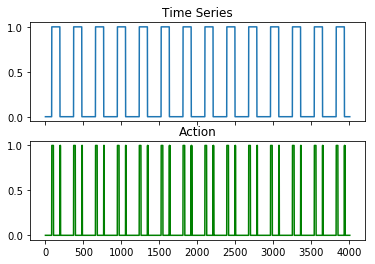

Precision:0.0027397260274, Recall:1.0, F1-score:0.00546448087432 (f1 wrote to file)
Episode 2/58


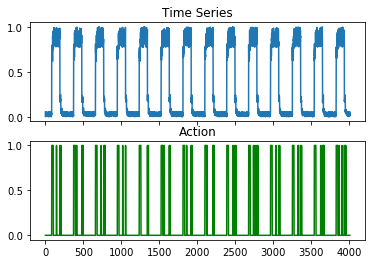

Precision:0.00282485875706, Recall:1.0, F1-score:0.0056338028169 (f1 wrote to file)
Episode 3/58


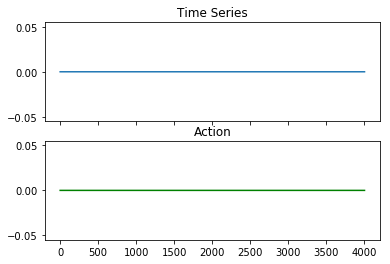

Precision:1.0, Recall:1.0, F1-score:1.0 (f1 wrote to file)
Episode 4/58


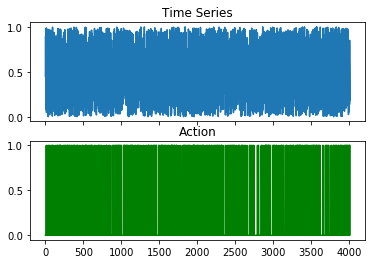

Precision:0.00211416490486, Recall:1.0, F1-score:0.0042194092827 (f1 wrote to file)
Episode 5/58


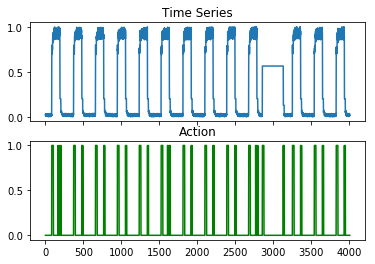

Precision:0.566423357664, Recall:0.960396039604, F1-score:0.712580348944 (f1 wrote to file)
Episode 6/58


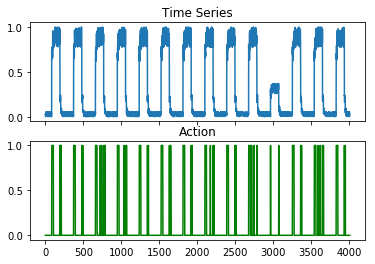

Precision:0.546478873239, Recall:0.960396039604, F1-score:0.696588868941 (f1 wrote to file)
Episode 7/58


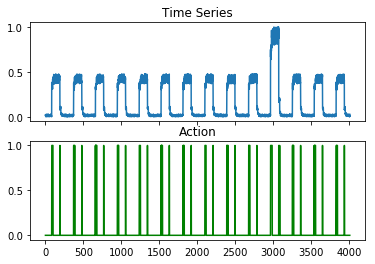

Precision:0.665523156089, Recall:0.960396039604, F1-score:0.786220871327 (f1 wrote to file)
Episode 8/58


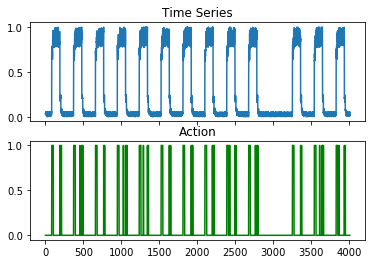

Precision:0.558782849239, Recall:1.0, F1-score:0.716947648625 (f1 wrote to file)
Episode 9/58


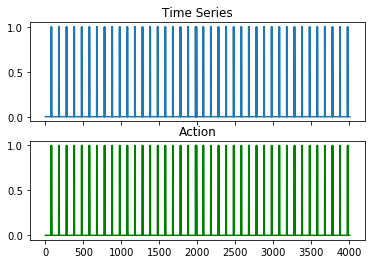

Precision:0.792156862745, Recall:1.0, F1-score:0.884026258206 (f1 wrote to file)
Episode 10/58


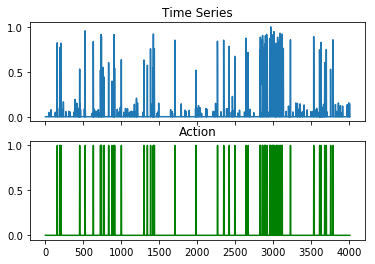

Precision:0.761658031088, Recall:0.727722772277, F1-score:0.744303797468 (f1 wrote to file)
Episode 11/58


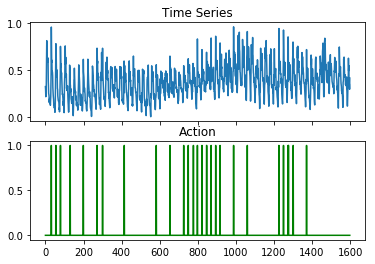

Precision:0.818181818182, Recall:0.713414634146, F1-score:0.762214983713 (f1 wrote to file)
Episode 12/58


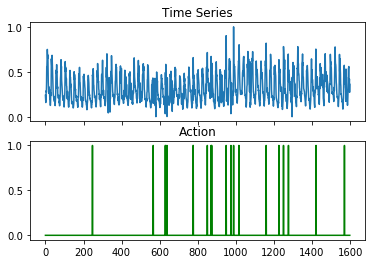

Precision:0.869918699187, Recall:0.656441717791, F1-score:0.748251748252 (f1 wrote to file)
Episode 13/58


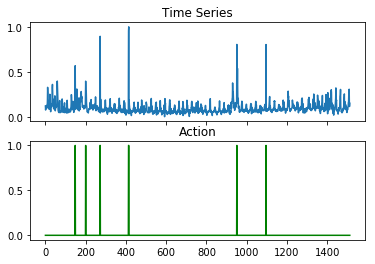

Precision:0.969387755102, Recall:0.616883116883, F1-score:0.753968253968 (f1 wrote to file)
Episode 14/58


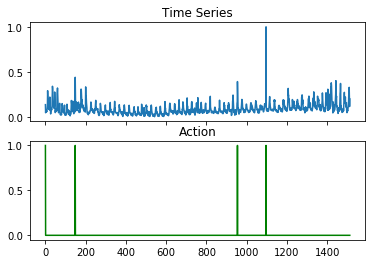

Precision:0.96511627907, Recall:0.538961038961, F1-score:0.691666666667 (f1 wrote to file)
Episode 15/58


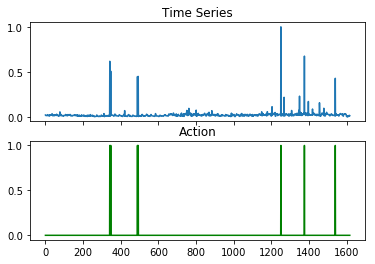

Precision:0.943661971831, Recall:0.403614457831, F1-score:0.565400843882 (f1 wrote to file)
Episode 16/58


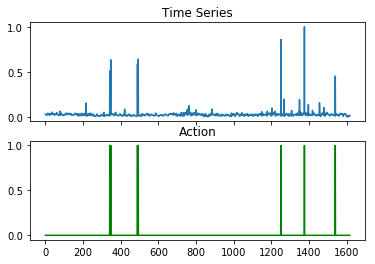

Precision:0.963414634146, Recall:0.478787878788, F1-score:0.63967611336 (f1 wrote to file)
Episode 17/58


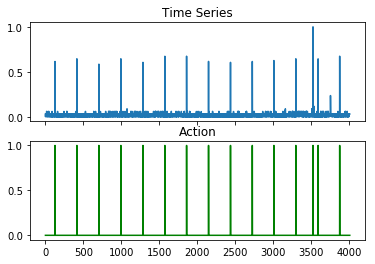

Precision:0.891666666667, Recall:0.265508684864, F1-score:0.409177820268 (f1 wrote to file)
Episode 18/58


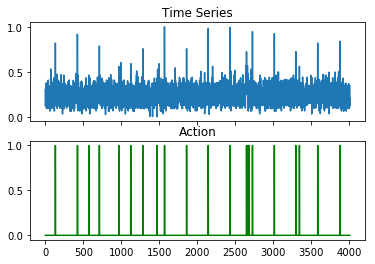

Precision:0.926940639269, Recall:0.503722084367, F1-score:0.652733118971 (f1 wrote to file)
Episode 19/58


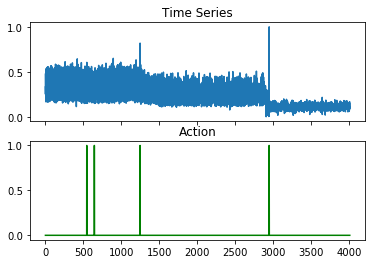

Precision:0.988571428571, Recall:0.429280397022, F1-score:0.598615916955 (f1 wrote to file)
Episode 20/58


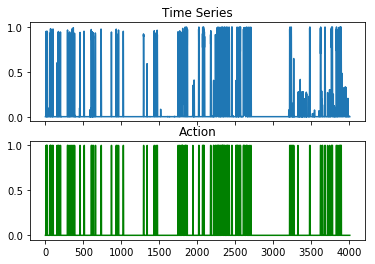

Precision:0.537234042553, Recall:1.0, F1-score:0.698961937716 (f1 wrote to file)
Episode 21/58


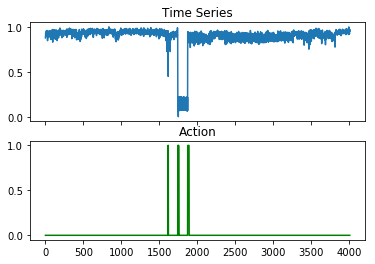

Precision:0.925196850394, Recall:0.683139534884, F1-score:0.785953177258 (f1 wrote to file)
Episode 22/58


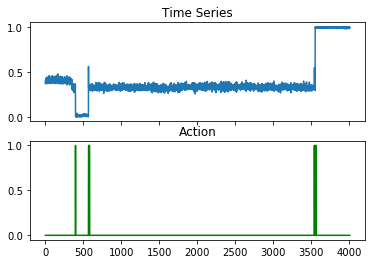

Precision:0.931623931624, Recall:0.539603960396, F1-score:0.683385579937 (f1 wrote to file)
Episode 23/58


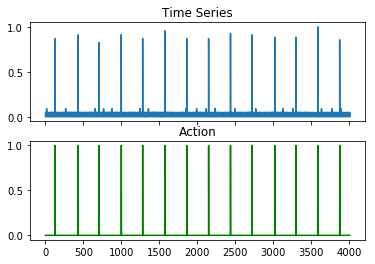

Precision:0.0555555555556, Recall:1.0, F1-score:0.105263157895 (f1 wrote to file)
Episode 24/58


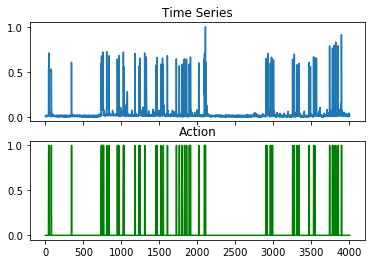

Precision:0.540453074434, Recall:0.411330049261, F1-score:0.467132867133 (f1 wrote to file)
Episode 25/58


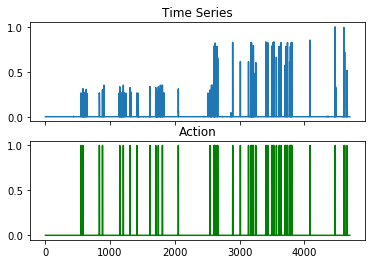

Precision:0.841961852861, Recall:0.651898734177, F1-score:0.734839476813 (f1 wrote to file)
Episode 26/58


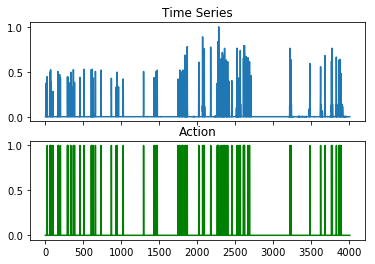

Precision:0.747540983607, Recall:0.56157635468, F1-score:0.64135021097 (f1 wrote to file)
Episode 27/58


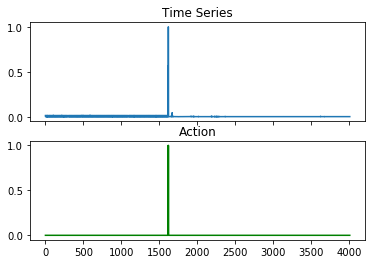

Precision:1.0, Recall:0.509900990099, F1-score:0.675409836066 (f1 wrote to file)
Episode 28/58


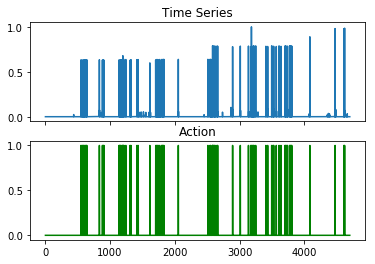

Precision:0.857476635514, Recall:0.772631578947, F1-score:0.81284606866 (f1 wrote to file)
Episode 29/58


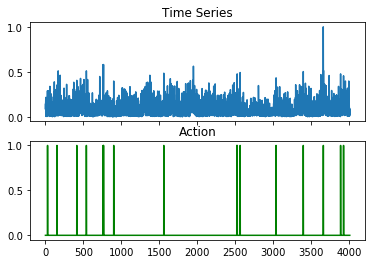

Precision:0.941964285714, Recall:0.523573200993, F1-score:0.673046251994 (f1 wrote to file)
Episode 30/58


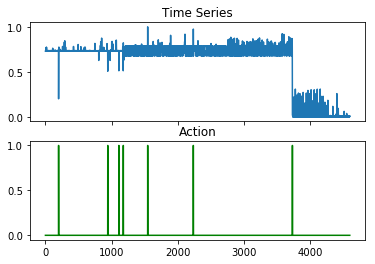

Precision:0.987012987013, Recall:0.652360515021, F1-score:0.785529715762 (f1 wrote to file)
Episode 31/58


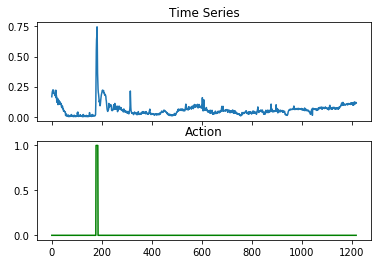

Precision:0.111111111111, Recall:0.00787401574803, F1-score:0.0147058823529 (f1 wrote to file)
Episode 32/58


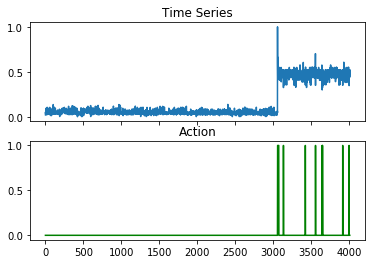

Precision:0.986046511628, Recall:0.526054590571, F1-score:0.686084142395 (f1 wrote to file)
Episode 33/58


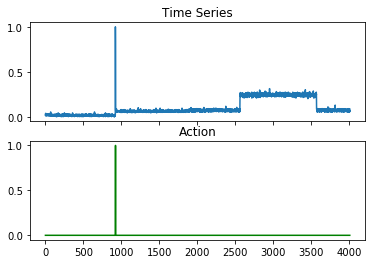

Precision:1.0, Recall:0.265508684864, F1-score:0.419607843137 (f1 wrote to file)
Episode 34/58


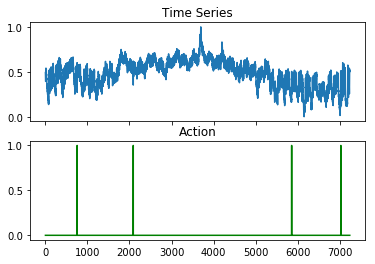

Precision:0.166666666667, Recall:0.00137551581843, F1-score:0.00272851296044 (f1 wrote to file)
Episode 35/58


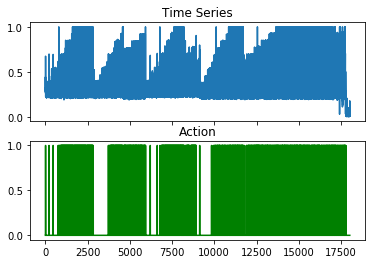

Precision:0.565759637188, Recall:0.998, F1-score:0.722141823444 (f1 wrote to file)
Episode 36/58


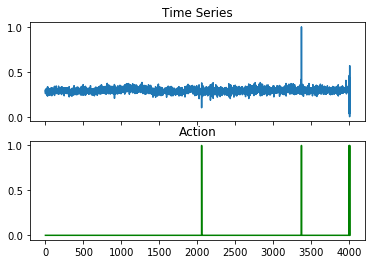

Precision:1.0, Recall:0.466858789625, F1-score:0.636542239686 (f1 wrote to file)
Episode 37/58


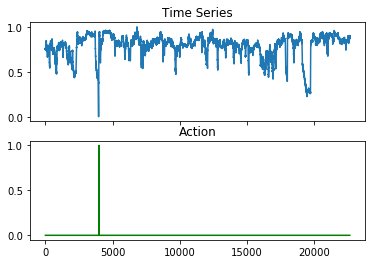

Precision:1.0, Recall:0.120758043191, F1-score:0.2154935116 (f1 wrote to file)
Episode 38/58


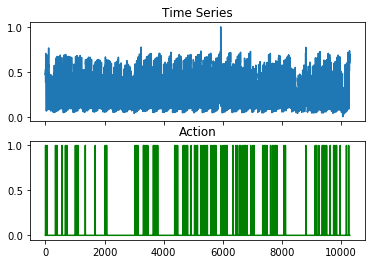

Precision:0.800786369594, Recall:0.589768339768, F1-score:0.679266259033 (f1 wrote to file)
Episode 39/58


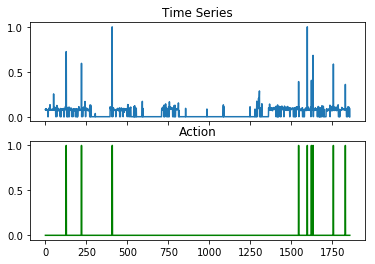

Precision:0.0909090909091, Recall:0.00523560209424, F1-score:0.00990099009901 (f1 wrote to file)
Episode 40/58


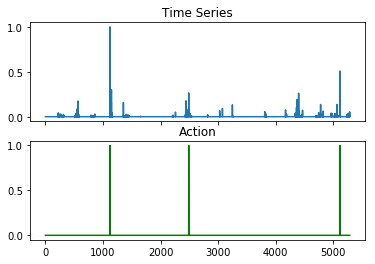

Precision:0.2, Recall:0.00188323917137, F1-score:0.00373134328358 (f1 wrote to file)
Episode 41/58


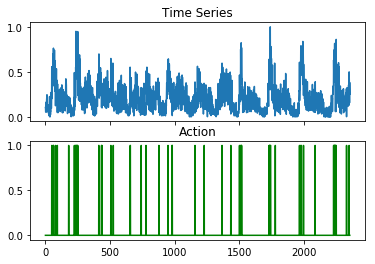

Precision:0.673366834171, Recall:0.558333333333, F1-score:0.610478359909 (f1 wrote to file)
Episode 42/58


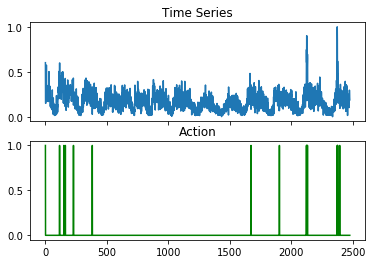

Precision:0.945578231293, Recall:0.553784860558, F1-score:0.698492462312 (f1 wrote to file)
Episode 43/58


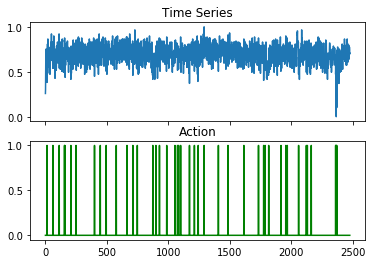

Precision:0.753086419753, Recall:0.508333333333, F1-score:0.606965174129 (f1 wrote to file)
Episode 44/58


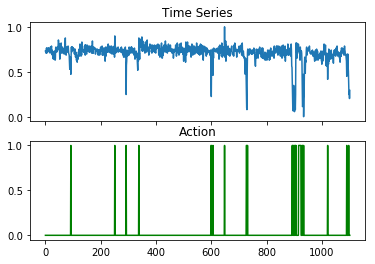

Precision:0.906542056075, Recall:0.82905982906, F1-score:0.866071428571 (f1 wrote to file)
Episode 45/58


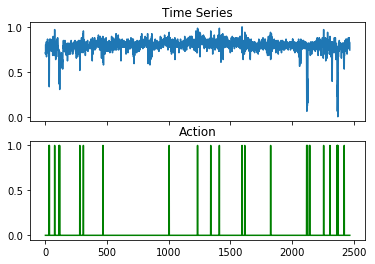

Precision:0.895061728395, Recall:0.577689243028, F1-score:0.702179176755 (f1 wrote to file)
Episode 46/58


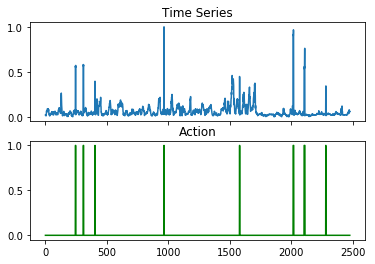

Precision:0.811965811966, Recall:0.38, F1-score:0.517711171662 (f1 wrote to file)
Episode 47/58


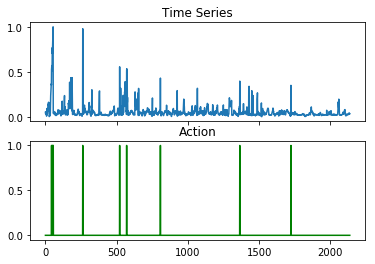

Precision:0.8984375, Recall:0.52752293578, F1-score:0.664739884393 (f1 wrote to file)
Episode 48/58


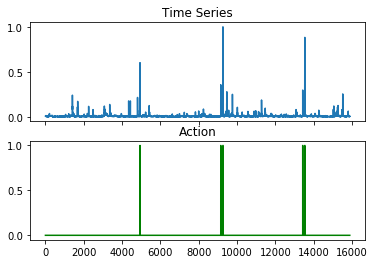

Precision:0.984962406015, Recall:0.32976714915, F1-score:0.494106553512 (f1 wrote to file)
Episode 49/58


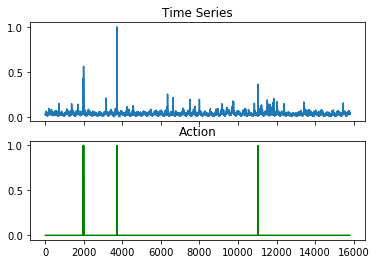

Precision:0.99511002445, Recall:0.25743200506, F1-score:0.409045226131 (f1 wrote to file)
Episode 50/58


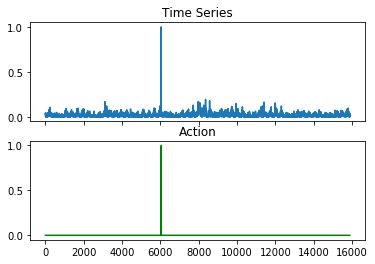

Precision:1.0, Recall:0.170639899624, F1-score:0.291532690247 (f1 wrote to file)
Episode 51/58


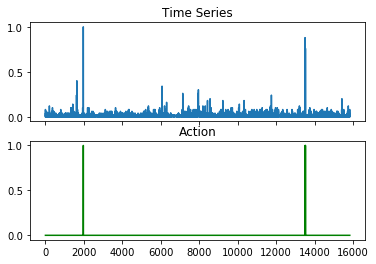

Precision:1.0, Recall:0.281597904388, F1-score:0.4394481349 (f1 wrote to file)
Episode 52/58


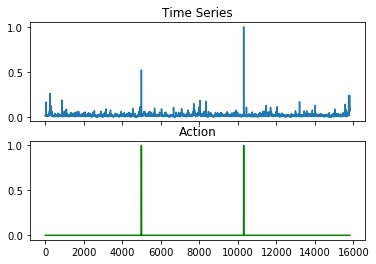

Precision:1.0, Recall:0.507896399242, F1-score:0.673648931713 (f1 wrote to file)
Episode 53/58


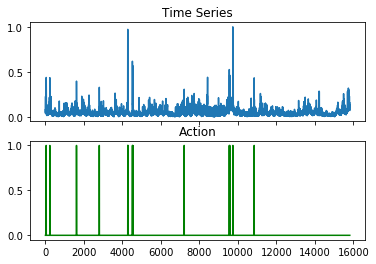

Precision:0.991124260355, Recall:0.467550593161, F1-score:0.63537221432 (f1 wrote to file)
Episode 54/58


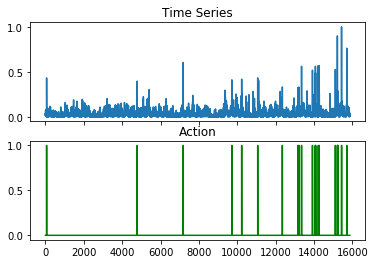

Precision:0.977540106952, Recall:0.574481458202, F1-score:0.723673792557 (f1 wrote to file)
Episode 55/58


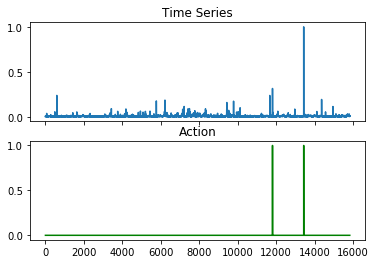

Precision:1.0, Recall:0.340680100756, F1-score:0.508219821512 (f1 wrote to file)
Episode 56/58


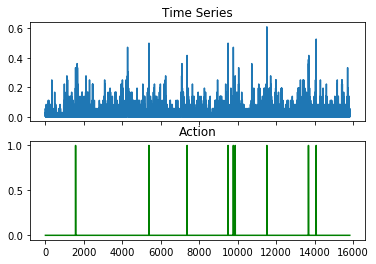

Precision:0.983173076923, Recall:0.257394587791, F1-score:0.407980049875 (f1 wrote to file)
Episode 57/58


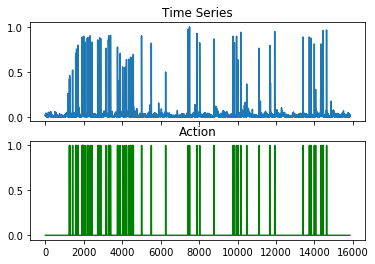

Precision:0.776176753122, Recall:0.509457755359, F1-score:0.615150361629 (f1 wrote to file)
Episode 58/58


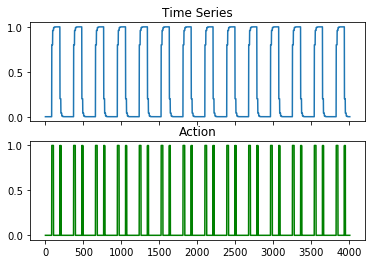

Precision:0.0027397260274, Recall:1.0, F1-score:0.00546448087432 (f1 wrote to file)


In [10]:
test = 1
plot = 1

percentage = ['1']

for j in range(len(percentage)):
    # Where we save our checkpoints and graphs
    # exp_relative_dir = ['RNN Binary d0 s25 h64 b256 A1_partial_data_' + percentage[j], 'RNN Binary d0 s25 h64 b256 A2_partial_data_' + percentage[j],
    #                     'RNN Binary d0 s25 h64 b256 A3_partial_data_' + percentage[j], 'RNN Binary d0 s25 h64 b256 A4_partial_data_' + percentage[j]]
    # exp_relative_dir = ['RNN Binary d0.9 s25 h64 b256 A4_partial_data_' + percentage[j]]
    exp_relative_dir = ['RNN Binary d0.9 s25 h64 b256 A1-4_all_data']

    # Which dataset we are targeting
    # dataset_dir = ['env/time_series_repo/A1Benchmark', 'env/time_series_repo/A2Benchmark',
    #                'env/time_series_repo/A3Benchmark', 'env/time_series_repo/A4Benchmark']
    # dataset_dir = ['env/time_series_repo/A4Benchmark']
    dataset_dir = ['env/numenta/']

    # Where we save the testing results
    # record_dir = ['d0A1p065.csv', 'd0A2p065.csv', 'd0A3p065.csv', 'd0A4p065.csv']
    record_dir = ['file.csv']
    
    for i in range(len(dataset_dir)):

        env = EnvTimeSeriesfromRepo(dataset_dir[i])
        env.statefnc = RNNBinaryStateFuc
        env.rewardfnc = RNNBinaryRewardFuc
        env.timeseries_curser_init = n_steps
        env.datasetfix = DATAFIXED
        
        if test==1:
            env.datasetrng = env.datasetsize
        else:
            env.datasetrng = np.int32(env.datasetsize * float(percentage[j]))
            
        env.datasetidx = 0

        experiment_dir = os.path.abspath("./exp/{}".format(exp_relative_dir[i]))

        tf.reset_default_graph()

        global_step = tf.Variable(0, name="global_step", trainable=False)

        qlearn_estimator = Q_Estimator_Nonlinear(scope="qlearn", summaries_dir=experiment_dir)
        target_estimator = Q_Estimator_Nonlinear(scope="target")

        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        with sess.as_default():
            q_learning(env,
                       qlearn_estimator=qlearn_estimator,
                       target_estimator=target_estimator,
                       num_episodes=2000,
                       num_epoches=10,
                       experiment_dir=experiment_dir,
                       replay_memory_size=50000,
                       replay_memory_init_size=50000,
                       update_target_estimator_every=10,
                       epsilon_start=1.0,
                       epsilon_end=0.1,
                       epsilon_decay_steps=500000,
                       discount_factor=0.9,
                       batch_size=256,
                       test=test)

            q_learning_validator(env, qlearn_estimator, env.datasetsize, record_dir[i], plot)